## Fundamental Matrix Estimation From Point Correspondences


In [150]:
import numpy as np
from scipy.misc import imread
import matplotlib.pyplot as plt
import scipy.io as sio
from epipolar_utils import *



### (a) Implement the linear least-squares eight point algorithm in lls_eight_point_alg()

In [151]:
'''
LLS_EIGHT_POINT_ALG  computes the fundamental matrix from matching points using 
linear least squares eight point algorithm
Arguments:
    points1 - N points in the first image that match with points2
    points2 - N points in the second image that match with points1

    Both points1 and points2 are from the get_data_from_txt_file() method
Returns:
    F - the fundamental matrix such that (points2)^T * F * points1 = 0
Please see lecture notes and slides to see how the linear least squares eight
point algorithm works
'''
def lls_eight_point_alg(points1, points2):
    def get_w_raw(point1, point2):
        return np.array([
            point1[0] * point2[0],
            point1[0] * point2[1],
            point1[0],
            point1[1] * point2[0],
            point1[1] * point2[1],
            point1[1],
            point2[0],
            point2[1],
            1
        ])
    
    W = np.zeros((points1.shape[0], 9))
    
    for idx in range(0, points1.shape[0]):
        W[idx, :] = get_w_raw(points1[idx], points2[idx])
        
    #print ("W\n", W)
    
    U, s, V = np.linalg.svd(W)
    #print ("U\n", U)
    #print ("s\n", s)
    #print ("V\n", V[8, :])
    
    F_cap = np.reshape(V[8, :], (3, 3))
    #print ("F_cap\n", F_cap)
    
    U, s, V = np.linalg.svd(F_cap)
    
    s_rank2 = np.zeros((s.shape[0], s.shape[0]))
    s_rank2[0, 0] = s[0]
    s_rank2[1, 1] = s[1]
    F = np.dot(U, np.dot(s_rank2, V))
    
    return F

### (b) Implement the normalized eight point algorithm in normalized_eight_point_alg()

In [152]:
'''
NORMALIZED_EIGHT_POINT_ALG  computes the fundamental matrix from matching points
using the normalized eight point algorithm
Arguments:
    points1 - N points in the first image that match with points2
    points2 - N points in the second image that match with points1

    Both points1 and points2 are from the get_data_from_txt_file() method
Returns:
    F - the fundamental matrix such that (points2)^T * F * points1 = 0
Please see lecture notes and slides to see how the normalized eight
point algorithm works
'''
def normalized_eight_point_alg(points1, points2):
    
    def get_normalization_matrix(points):
        mean = np.mean(points, axis = 0)
        #print (mean)
        dist = points - mean
        #print ("Dist\n", dist)
        #print ("Dist.shape\n", dist.shape)
        #print ("Total dist\n", np.sqrt(np.diag(np.dot(dist, dist.T))))
        mean_dist = np.mean(np.sqrt(np.diag(np.dot(dist, dist.T))))
        #print ("Mean_dist\n", mean_dist)
        #print ("Mean_dist.shape\n", mean_dist.shape)
        T = np.zeros((3, 3))
        T[0][0] = (np.sqrt(2) / mean_dist)
        T[0][2] = -1 * mean[0] * (np.sqrt(2) / mean_dist)
        T[1][1] = (np.sqrt(2) / mean_dist)
        T[1][2] = -1 * mean[1] * (np.sqrt(2) / mean_dist)
        T[2, :] = [0, 0, 1]
        return T

    
    T1 = get_normalization_matrix(points1)
    T2 = get_normalization_matrix(points2)
    #print (T1)
    #print (T2)
    
    points1_norm = np.dot(T1, points1.T).T
    points2_norm = np.dot(T2, points2.T).T    
    #print ("Points1.norm\n", points1_norm)
    #print ("Points2.norm\n", points2_norm)

    F_norm = lls_eight_point_alg(points1_norm, points2_norm)    
    F = np.dot(np.dot(T1.T, F_norm), T2)
    #F = T1.T * F_norm * T2
    return F



### (c) Fill out the method plot_epipolar_lines_on_images()

In [153]:
import matplotlib.patches as patches
import matplotlib.lines as lines

'''
PLOT_EPIPOLAR_LINES_ON_IMAGES given a pair of images and corresponding points,
draws the epipolar lines on the images
Arguments:
    points1 - N points in the first image that match with points2
    points2 - N points in the second image that match with points1
    im1 - a HxW(xC) matrix that contains pixel values from the first image 
    im2 - a HxW(xC) matrix that contains pixel values from the second image 
    F - the fundamental matrix such that (points2)^T * F * points1 = 0

    Both points1 and points2 are from the get_data_from_txt_file() method
Returns:
    Nothing; instead, plots the two images with the matching points and
    their corresponding epipolar lines. See Figure 1 within the problem set
    handout for an example
'''
def plot_epipolar_lines_on_images(points1, points2, im1, im2, F):
    def find_crossing_coords(l, im):
        y_x_0 = int(-1 * l[2] / l[1])
        y_x_max =  int(-1 * l[2] - l[0] * im.shape[1] / l[1])
        x_y_0 = int(-1 * l[2] / l[0])
        x_y_max =  int(-1 * l[2] - l[1] * im.shape[0] / l[0])
        
        line = []
        if (y_x_0 >= 0 and y_x_0 <= im.shape[1]):
            line.append((0, y_x_0))
        if (y_x_max >= 0 and y_x_max <= im.shape[1]):
            line.append((im.shape[0], y_x_max))
        if (x_y_0 >= 0 and x_y_0 <= im.shape[0]):
            line.append((x_y_0, 0))
        if (x_y_max >= 0 and x_y_max <= im.shape[0]):
            line.append((x_y_max, im.shape[1]))
        return line
        
    fig = plt.figure(figsize = (50, 20))
    image1 = fig.add_subplot(1, 10, 1)
    image1.imshow(im1)
    for point in points1:
        circ = patches.Circle((point[0], point[1]), 6, linewidth=1,edgecolor='b',facecolor='none')
        image1.add_patch(circ)
    
    for idx in range(0, points1.shape[0]):
        l = np.dot(F, points2[idx])
        line = find_crossing_coords(l, im1)
        if len(line) == 2:
            (line_xs, line_ys) = zip(*line)
            image1.add_line(lines.Line2D(line_xs, line_ys, linewidth=1, color='red'))
        
    image2 = fig.add_subplot(1, 10, 2)
    image2.imshow(im2)
    for point in points2:
        circ = patches.Circle((point[0], point[1]), 6, linewidth=1,edgecolor='b',facecolor='none')
        image2.add_patch(circ)
    
    for idx in range(0, points1.shape[0]):
        l = np.dot(F.T, points1[idx])
        line = find_crossing_coords(l, im2)
        if len(line) == 2:
            (line_xs, line_ys) = zip(*line)
            image2.add_line(lines.Line2D(line_xs, line_ys, linewidth=1, color='red'))
    
    plt.show()


### (d) Determine epipolar lines

In [154]:
'''
COMPUTE_DISTANCE_TO_EPIPOLAR_LINES  computes the average distance of a set a 
points to their corresponding epipolar lines
Arguments:
    points1 - N points in the first image that match with points2
    points2 - N points in the second image that match with points1
    F - the fundamental matrix such that (points2)^T * F * points1 = 0

    Both points1 and points2 are from the get_data_from_txt_file() method
Returns:
    average_distance - the average distance of each point to the epipolar line
'''
def compute_distance_to_epipolar_lines(points1, points2, F):
    #print ("F.shape\n", F.shape)
    #print ("Points2.shape\n", points2.shape)
    l = np.dot(F, points2.T)
    #print ("l.shape\n", l.shape)
    dist = np.absolute(np.diag(np.dot(l.T, points1.T)))
    #print ("dist.shape\n", dist.shape)
    l_ab = l.T[:, [1, 2]]
    #print ("l_ab.shape\n", l_ab.shape)
    div = np.sqrt(np.diag(np.dot(l_ab, l_ab.T)))
    #print ("div.shape\n", div.shape)
    dist = dist * (1. / div)
    #print ("dist\n", dist)
    return np.mean(dist)
    

------------------------------------
Set:data/set1
------------------------------------
('W\n', array([[  1.67085000e+05,   1.41410000e+05,   3.95000000e+02,
          2.00079000e+05,   1.69334000e+05,   4.73000000e+02,
          4.23000000e+02,   3.58000000e+02,   1.00000000e+00],
       [  9.21060000e+04,   7.43470000e+04,   3.01000000e+02,
          8.50680000e+04,   6.86660000e+04,   2.78000000e+02,
          3.06000000e+02,   2.47000000e+02,   1.00000000e+00],
       [  1.11888000e+05,   6.21600000e+04,   3.36000000e+02,
          7.29270000e+04,   4.05150000e+04,   2.19000000e+02,
          3.33000000e+02,   1.85000000e+02,   1.00000000e+00],
       [  4.86500117e+04,   5.44810958e+04,   2.08000000e+02,
          6.08125146e+04,   6.81013697e+04,   2.60000000e+02,
          2.33894287e+02,   2.61928345e+02,   1.00000000e+00],
       [  4.86720000e+04,   4.75280000e+04,   2.08000000e+02,
          5.26500000e+04,   5.14125000e+04,   2.25000000e+02,
          2.34000000e+02,   2.28

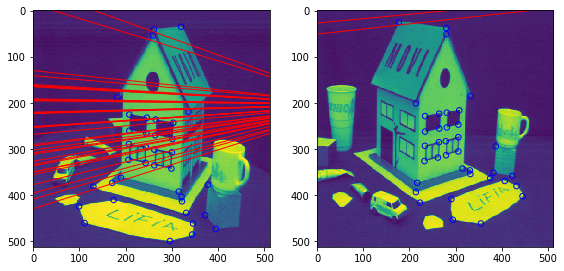

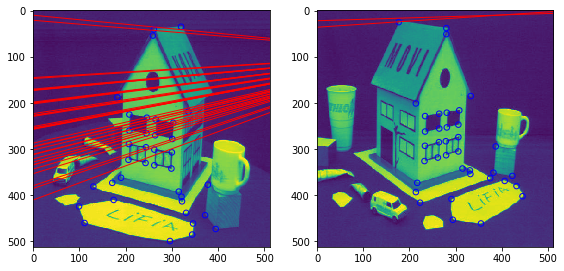

------------------------------------
Set:data/set2
------------------------------------
('W\n', array([[  7.22800000e+04,   9.73000000e+03,   2.78000000e+02,
          9.88000000e+03,   1.33000000e+03,   3.80000000e+01,
          2.60000000e+02,   3.50000000e+01,   1.00000000e+00],
       [  1.04490000e+04,   3.35400000e+03,   1.29000000e+02,
          1.94400000e+03,   6.24000000e+02,   2.40000000e+01,
          8.10000000e+01,   2.60000000e+01,   1.00000000e+00],
       [  2.96410933e+04,   1.43714392e+04,   1.79642990e+02,
          1.25871804e+04,   6.10287536e+03,   7.62859420e+01,
          1.65000000e+02,   8.00000000e+01,   1.00000000e+00],
       [  5.60690000e+04,   6.01550000e+04,   2.27000000e+02,
          6.54550000e+04,   7.02250000e+04,   2.65000000e+02,
          2.47000000e+02,   2.65000000e+02,   1.00000000e+00],
       [  9.24600000e+04,   8.79750000e+04,   3.45000000e+02,
          7.34320000e+04,   6.98700000e+04,   2.74000000e+02,
          2.68000000e+02,   2.55

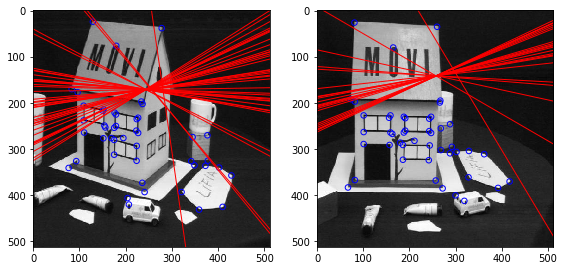

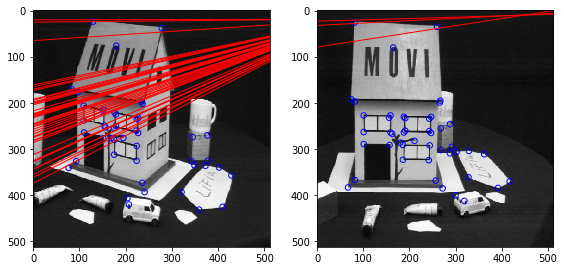

In [155]:

for im_set in ['data/set1', 'data/set2']:
    print ('------------------------------------')
    print ('Set:%s' % im_set)
    print ('------------------------------------')

    # Read in the data
    im1 = imread(im_set+'/image1.jpg')
    im2 = imread(im_set+'/image2.jpg')
    points1 = get_data_from_txt_file(im_set+'/pt_2D_1.txt')
    points2 = get_data_from_txt_file(im_set+'/pt_2D_2.txt')
    assert (points1.shape == points2.shape)

    # Running the linear least squares eight point algorithm
    F_lls = lls_eight_point_alg(points1, points2)
    print ("Fundamental Matrix from LLS  8-point algorithm:\n", F_lls)
    print ("Distance to lines in image 1 for LLS:", \
        compute_distance_to_epipolar_lines(points1, points2, F_lls))
    print ("Distance to lines in image 2 for LLS:", \
        compute_distance_to_epipolar_lines(points2, points1, F_lls.T))

    # Running the normalized eight point algorithm
    F_normalized = normalized_eight_point_alg(points1, points2)

    pFp = [points2[i].dot(F_normalized.dot(points1[i])) 
        for i in xrange(points1.shape[0])]
    print ("p'^T F p =", np.abs(pFp).max())
    print ("Fundamental Matrix from normalized 8-point algorithm:\n", \
        F_normalized)
    print ("Distance to lines in image 1 for normalized:", \
        compute_distance_to_epipolar_lines(points1, points2, F_normalized))
    print ("Distance to lines in image 2 for normalized:", \
        compute_distance_to_epipolar_lines(points2, points1, F_normalized.T))

    # Plotting the epipolar lines
    plot_epipolar_lines_on_images(points1, points2, im1, im2, F_lls)
    plot_epipolar_lines_on_images(points1, points2, im1, im2, F_normalized)

    plt.show()


## 4 Triangulation in Structure From Motion

In [127]:
import sys
import numpy as np
import os
import scipy.misc
from scipy.optimize import least_squares
import math
from copy import deepcopy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sfm_utils import *

### Implement the function estimate_initial_RT()

In [147]:
'''
ESTIMATE_INITIAL_RT from the Essential Matrix, we can compute 4 initial
guesses of the relative RT between the two cameras
Arguments:
    E - the Essential Matrix between the two cameras
Returns:
    RT: A 4x3x4 tensor in which the 3x4 matrix RT[i,:,:] is one of the
        four possible transformations
'''
def estimate_initial_RT(E):
    W = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
    print ("W\n", W)
    U, S, V = np.linalg.svd(E)
    Q1 = np.dot(U, np.dot(W, V))
    Q2 = np.dot(U, np.dot(W.T, V))
    R1 = np.linalg.det(Q1) * Q1
    R2 = np.linalg.det(Q2) * Q2
    
    print ("R1\n", R1)
    print ("R2\n", R2)
    
    print ("U\n", U)
    T1 = U[:, 2]
    print ("T1\n", T1)
    T2 = -1 * T1
    
    RT = np.zeros((4, 3, 4))
    RT[0, :, :] = np.concatenate((R1, np.reshape(T1, (3, 1))), axis = 1)
    RT[1, :, :] = np.concatenate((R1, np.reshape(T2, (3, 1))), axis = 1)
    RT[2, :, :] = np.concatenate((R2, np.reshape(T1, (3, 1))), axis = 1)
    RT[3, :, :] = np.concatenate((R2, np.reshape(T2, (3, 1))), axis = 1)

    return RT

###  The linear estimate of 3D point in linear_estimate_3d_point()

In [167]:
'''
LINEAR_ESTIMATE_3D_POINT given a corresponding points in different images,
compute the 3D point is the best linear estimate
Arguments:
    image_points - the measured points in each of the M images (Mx2 matrix)
    camera_matrices - the camera projective matrices (Mx3x4 tensor)
Returns:
    point_3d - the 3D point
'''
def linear_estimate_3d_point(image_points, camera_matrices):
    print ("Image points\n", image_points)
    print ("camera_matrices\n", camera_matrices)
    A = np.zeros((2 * image_points.shape[0], 4))
    for idx in range(0, image_points.shape[0]):
        A[2*idx, :] = image_points[idx][0] * camera_matrices[idx, 2, :] - camera_matrices[idx, 0, :]
        A[2*idx + 1, :] = image_points[idx][1] * camera_matrices[idx, 2, :] - camera_matrices[idx, 1, :]
        
    #print ("A\n", A)
    U, S, V = np.linalg.svd(A)
    #print ("V\n", V)
    #print (V[-1, :])
    p3d = V[-1, [0, 1, 2]] / V[-1, 3]
    return p3d
    

In [168]:
'''
REPROJECTION_ERROR given a 3D point and its corresponding points in the image
planes, compute the reprojection error vector and associated Jacobian
Arguments:
    point_3d - the 3D point corresponding to points in the image
    image_points - the measured points in each of the M images (Mx2 matrix)
    camera_matrices - the camera projective matrices (Mx3x4 tensor)
Returns:
    error - the 2Mx1 reprojection error vector
'''
def reprojection_error(point_3d, image_points, camera_matrices):
    # TODO: Implement this method!
    raise Exception('Not Implemented Error')


In [169]:
run_pipeline = True

# Load the data
image_data_dir = 'data/statue/'
unit_test_camera_matrix = np.load('data/unit_test_camera_matrix.npy')
unit_test_image_matches = np.load('data/unit_test_image_matches.npy')
image_paths = [os.path.join(image_data_dir, 'images', x) for x in
    sorted(os.listdir('data/statue/images')) if '.jpg' in x]
focal_length = 719.5459
matches_subset = np.load(os.path.join(image_data_dir,
    'matches_subset.npy'))[0,:]
dense_matches = np.load(os.path.join(image_data_dir, 'dense_matches.npy'))
fundamental_matrices = np.load(os.path.join(image_data_dir,
    'fundamental_matrices.npy'))[0,:]

# Part A: Computing the 4 initial R,T transformations from Essential Matrix
print '-' * 80
print "Part A: Check your matrices against the example R,T"
print '-' * 80
K = np.eye(3)
K[0,0] = K[1,1] = focal_length
E = K.T.dot(fundamental_matrices[0]).dot(K)
im0 = scipy.misc.imread(image_paths[0])
im_height, im_width, _ = im0.shape
example_RT = np.array([[0.9736, -0.0988, -0.2056, 0.9994],
    [0.1019, 0.9948, 0.0045, -0.0089],
    [0.2041, -0.0254, 0.9786, 0.0331]])
print "Example RT:\n", example_RT
estimated_RT = estimate_initial_RT(E)
print
print "Estimated RT:\n", estimated_RT

# Part B: Determining the best linear estimate of a 3D point
print '-' * 80
print 'Part B: Check that the difference from expected point '
print 'is near zero'
print '-' * 80
camera_matrices = np.zeros((2, 3, 4))
camera_matrices[0, :, :] = K.dot(np.hstack((np.eye(3), np.zeros((3,1)))))
camera_matrices[1, :, :] = K.dot(example_RT)
unit_test_matches = matches_subset[0][:,0].reshape(2,2)
estimated_3d_point = linear_estimate_3d_point(unit_test_matches.copy(),
    camera_matrices.copy())
expected_3d_point = np.array([0.6774, -1.1029, 4.6621])
print "Difference: ", np.fabs(estimated_3d_point - expected_3d_point).sum()

# Part C: Calculating the reprojection error and its Jacobian
print '-' * 80
print 'Part C: Check that the difference from expected error/Jacobian '
print 'is near zero'
print '-' * 80
estimated_error = reprojection_error(
        expected_3d_point, unit_test_matches, camera_matrices)
estimated_jacobian = jacobian(expected_3d_point, camera_matrices)
expected_error = np.array((-0.0095458, -0.5171407,  0.0059307,  0.501631))
print "Error Difference: ", np.fabs(estimated_error - expected_error).sum()
expected_jacobian = np.array([[ 154.33943931, 0., -22.42541691],
     [0., 154.33943931, 36.51165089],
     [141.87950588, -14.27738422, -56.20341644],
     [21.9792766, 149.50628901, 32.23425643]])
print "Jacobian Difference: ", np.fabs(estimated_jacobian
    - expected_jacobian).sum()

# Part D: Determining the best nonlinear estimate of a 3D point
print '-' * 80
print 'Part D: Check that the reprojection error from nonlinear method'
print 'is lower than linear method'
print '-' * 80
estimated_3d_point_linear = linear_estimate_3d_point(
    unit_test_image_matches.copy(), unit_test_camera_matrix.copy())
estimated_3d_point_nonlinear = nonlinear_estimate_3d_point(
    unit_test_image_matches.copy(), unit_test_camera_matrix.copy())
error_linear = reprojection_error(
    estimated_3d_point_linear, unit_test_image_matches,
    unit_test_camera_matrix)
print "Linear method error:", np.linalg.norm(error_linear)
error_nonlinear = reprojection_error(
    estimated_3d_point_nonlinear, unit_test_image_matches,
    unit_test_camera_matrix)
print "Nonlinear method error:", np.linalg.norm(error_nonlinear)

# Part E: Determining the correct R, T from Essential Matrix
print '-' * 80
print "Part E: Check your matrix against the example R,T"
print '-' * 80
estimated_RT = estimate_RT_from_E(E,
    np.expand_dims(unit_test_image_matches[:2,:], axis=0), K)
print "Example RT:\n", example_RT
print
print "Estimated RT:\n", estimated_RT

# Part F: Run the entire Structure from Motion pipeline
if not run_pipeline:
    sys.exit()
print '-' * 80
print 'Part F: Run the entire SFM pipeline'
print '-' * 80
frames = [0] * (len(image_paths) - 1)
for i in xrange(len(image_paths)-1):
    frames[i] = Frame(matches_subset[i].T, focal_length,
            fundamental_matrices[i], im_width, im_height)
    bundle_adjustment(frames[i])
merged_frame = merge_all_frames(frames)

# Construct the dense matching
camera_matrices = np.zeros((2,3,4))
dense_structure = np.zeros((0,3))
for i in xrange(len(frames)-1):
    matches = dense_matches[i]
    camera_matrices[0,:,:] = merged_frame.K.dot(
        merged_frame.motion[i,:,:])
    camera_matrices[1,:,:] = merged_frame.K.dot(
            merged_frame.motion[i+1,:,:])
    points_3d = np.zeros((matches.shape[1], 3))
    use_point = np.array([True]*matches.shape[1])
    for j in xrange(matches.shape[1]):
        points_3d[j,:] = nonlinear_estimate_3d_point(
            matches[:,j].reshape((2,2)), camera_matrices)
    dense_structure = np.vstack((dense_structure, points_3d[use_point,:]))

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.scatter(dense_structure[:,0], dense_structure[:,1], dense_structure[:,2],
    c='k', depthshade=True, s=2)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_zlim(0, 10)
ax.view_init(-100, 90)

plt.show()


--------------------------------------------------------------------------------
Part A: Check your matrices against the example R,T
--------------------------------------------------------------------------------
Example RT:
[[ 0.9736 -0.0988 -0.2056  0.9994]
 [ 0.1019  0.9948  0.0045 -0.0089]
 [ 0.2041 -0.0254  0.9786  0.0331]]
('W\n', array([[ 0, -1,  0],
       [ 1,  0,  0],
       [ 0,  0,  1]]))
('R1\n', array([[ 0.98305251, -0.11787055, -0.14040758],
       [-0.11925737, -0.99286228, -0.00147453],
       [-0.13923158,  0.01819418, -0.99009269]]))
('R2\n', array([[ 0.97364135, -0.09878708, -0.20558119],
       [ 0.10189204,  0.99478508,  0.00454512],
       [ 0.2040601 , -0.02537241,  0.97862951]]))
('U\n', array([[ 0.00795869,  0.03334286,  0.99941228],
       [-0.87951446,  0.4757895 , -0.00886961],
       [-0.47580561, -0.87892696,  0.03311219]]))
('T1\n', array([ 0.99941228, -0.00886961,  0.03311219]))

Estimated RT:
[[[ 0.98305251 -0.11787055 -0.14040758  0.99941228]
  [-0.1

Exception: Not Implemented Error